# Проект андан

## Использованные библиотеки:

In [30]:
!pip install fake_useragent
from bs4 import BeautifulSoup
from bs4.element import Tag
import requests
import time
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Парсинг, очистка, вторичные признаки


In [ ]:
def get_information(url):
  response = requests.get(url, headers={'User-Agent': UserAgent().chrome})
  tree = BeautifulSoup(response.content, 'html.parser')
  return tree

In [ ]:
object_list = {'Русский язык': 'russkij-yazyk',
               'Математика': 'matematika-elementarnaya',
               'Английский язык': 'anglijskij-yazyk',
               'Биология': 'biologiya',
               'Обществознание': 'obshchestvoznanie',
               'Музыка': 'muzyka',
               'География': 'geografiya',
               'Информатика': 'informatika',
               'Испанский язык': 'ispanskij-yazyk',
               'Логопед' : 'logopedy',
               'Физика' : 'fizika',
               'Химия' : 'himiya',
               'Биология' : 'biologiya',
               'Экономика' : 'ekonomika'
               }

In [ ]:
def get_href():
  for key in object_list.keys():
    for i in range(1,7):
      url = f'https://repetitor.ru/repetitors/{object_list[key]}?page={i}&per-page=15'
      tree = get_information(url)
      tutors_raw = tree.body.find_all('div', {'class' : 'tutors__main'})
      tutors_cards = tutors_raw[0].find_all('li', {'class' : 'tutor-card'})
      cur_href = [item.div.a.get('href') for item in tutors_cards]
      cur_object = [key for i in range(len(cur_href))]
      all_href['href'].extend(cur_href)
      all_href['object_name'].extend(cur_object)
      time.sleep(0.4)

In [ ]:
all_href = {'href' : [], 'object_name' : []}
get_href()

In [ ]:
df_href = pd.DataFrame(all_href)

In [ ]:
print(df_href.shape)
df_href

(1170, 2)


,href,object_name
0,/view/repetitor-po-russkomu-yazyku-tkachenko-m...,Русский язык
1,/view/repetitor-po-russkomu-yazyku-alehina-yul...,Русский язык
2,/view/repetitor-po-russkomu-yazyku-rybina-mari...,Русский язык
3,/view/repetitor-po-russkomu-yazyku-gubina-elen...,Русский язык
4,/view/repetitor-po-russkomu-yazyku-mochenova-d...,Русский язык
...,...,...
1165,/view/repetitor-po-ekonomike-bodnar-irina-niko...,Экономика
1166,/view/repetitor-po-ekonomike-odnoral-oleg-igor...,Экономика
1167,/view/repetitor-po-ekonomike-potapova-elena-ni...,Экономика
1168,/view/repetitor-po-ekonomike-sabitova-albina-r...,Экономика


In [ ]:
from tqdm import tqdm

def get_tutor():
  for i in tqdm(range(df_href.shape[0])):
    url, object_name =  df_href.iloc[i]
    tree = get_information(f'https://repetitor.ru{url}')

    #страница! препода
    try:
      tutor_raw_inf = tree.body.find_all('div', {'class' : 'tutor__wrap'})[0]
    except:
      print(f'Объебос на странице {url}')
      continue

    #определяю предмет препода
    dict_raw['Предмет'].append(object_name)

    #сначала определяю, подтверждена ли личность преподавателя (True - подтверждена; False - нет)
    tutor_person_confirmed_raw = tutor_raw_inf.find('div', {'class' : 'tutor-badge-blue'})
    if type(tutor_person_confirmed_raw) == Tag:
      tutor_person_confirmed = True
    else:
      tutor_person_confirmed = False
    dict_raw['Личность подтверждена'].append(tutor_person_confirmed)

    #здесь я определяю стаж и статус
    try:
      status_staj_raw = tutor_raw_inf.find('p', {'class' : "tutor-head__meta"}).text.strip().split('\n')
      dict_raw['Статус'].append(status_staj_raw[0].split(', ')[0])
      dict_raw['Стаж'].append(status_staj_raw[-1].split()[0])
    except:
      dict_raw['Статус'].append(None)
      dict_raw['Стаж'].append(None)

    #определяю кол-во времени репета на сайте и кол-во заказов в работе
    try:
      onsite_orders_raw = tutor_raw_inf.find('div', {'class' : "tutor-head__activity"}).text.strip().split('/')
      onsite = onsite_orders_raw[0].split()[-2:]
      if onsite[0] == 'Меньше':
        real_onsite = 0
      else:
        real_onsite = int(onsite[0])/12 if onsite[1] in ['месяца', 'месяцев'] else onsite[0]
    except:
      real_onsite = None

    try:
      orders = onsite_orders_raw[1].strip().split()[0]
    except:
      orders = None

    dict_raw['На сайте'].append(real_onsite)
    dict_raw['Заказы в работе'].append(orders)

    #здесь я определяю оценку
    try:
      mark = tutor_raw_inf.find('div', {'class' : "tutor-head__rating-count"}).text.strip()
    except:
      mark = None
    dict_raw['Оценка'].append(mark)

    #здесь я определяю количество отзывов
    try:
      number_of_review = tutor_raw_inf.find('div', {'class' : "tutor-head__rating"}).a.text.strip().split()[0]
    except:
      number_of_review = None
    dict_raw['Количество отзывов'].append(number_of_review)

    #здесь я определяю формат занятий - дистанционно али очно
    try:
      format_of_study = tutor_raw_inf.find('div', {'class' : "tutor-format__switches tabs__switches"}).button.text
    except:
      format_of_study = None
    dict_raw['Формат обучения'].append(format_of_study)

    #здесь я определяю среднюю цену
    try:
      prices_raw = tutor_raw_inf.find('div', {'class' : "tutor-format__prices"})
      prices = prices_raw.find_all('td')[1::2]
      price = 0
      for price_elem in prices:
        price_currency, time_minute = str(price_elem).strip('</td>').split('/')
        price_without_currency = price_currency.split()[0]
        time_hour = int(time_minute.split()[0])/60
        price += float(price_without_currency) * time_hour
      price /= len(prices)
    except:
      price = None
    dict_raw['Цена'].append(price)

    #образование тьютора
    excellence = False
    try:
      tutor_education = tutor_raw_inf.find('table', {'class' : "tutor-education__table"}).span.text.strip()
      if 'С отличием' in tutor_education:
        excellence = True
        tutor_education = tutor_education[:tutor_education.rfind('С отличием')-2]
      elif 'с отличием' in tutor_education:
        excellence = True
        tutor_education = tutor_education[:tutor_education.rfind('с отличием')-2]
    except:
      tutor_education = None
    dict_raw['Образование'].append(tutor_education)

    #с отличием ли окончил?
    dict_raw['С отличием'].append(excellence)

    time.sleep(0.1)

In [ ]:
dict_raw = {
    'Личность подтверждена' : [],
    'Статус' : [],
    'Стаж' : [],
    'На сайте' : [],
    'Заказы в работе' : [],
    'Оценка' : [],
    'Количество отзывов' : [],
    'Формат обучения' : [],
    'Образование' : [],
    'Предмет' : [],
    'Цена' : [],
    'С отличием' : []
}

In [ ]:
get_tutor()
df_raw = pd.DataFrame(dict_raw)
df_raw

 82%|████████▏ | 956/1170 [50:57<11:24,  3.20s/it]

Объебос на странице /view/repetitor-po-fizike-smirnov-fëdor-dmitrievich-158266


,Личность подтверждена,Статус,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,Формат обучения,Образование,Предмет,Цена,С отличием
0,False,Частный преподаватель,7,6,105,5,51,Д,МГУ им. М.В. Ломоносова,Русский язык,2425.000000,False
1,True,Школьный преподаватель,12,5,81,5,36,Д,Воронежский государственный педагогический уни...,Русский язык,4187.500000,False
2,True,Преподаватель университета или колледжа,22,5,41,5,29,Д,Мичуринский государственный педагогический инс...,Русский язык,1625.000000,False
3,True,Частный преподаватель,5,4,26,4.88,17,Д,Всероссийский Государственный Институт Кинемат...,Русский язык,3921.875000,False
4,True,Частный преподаватель,7,6,36,5,12,Д,МГУ им. М.В. Ломоносова,Русский язык,6000.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
951,False,Студент,3,1,4,None,None,Д,МГТУ им. Н.Э.Баумана,Физика,1250.000000,False
952,True,Студент,3,1,None,None,None,Д,МГУ имени Ломоносова,Физика,1050.000000,False
953,True,Частный преподаватель,43,0.833333,1,None,None,Д,Курский государственный пединститут,Физика,1000.000000,False
954,False,Школьный преподаватель,36,0.666667,None,None,None,Д,Башкирский государственный университет,Физика,1000.000000,False


In [ ]:
# все запаршенные данные записываю в файл
df_raw.to_csv('parsing.csv', encoding='utf-8')

## Обработка данных и добавление вторичных признаков


In [68]:
# скачиваю данные в DataFrame из файла
df_raw = pd.read_csv('parsing.csv')
df_raw.drop(columns = ['Unnamed: 0'], inplace = True)
df_raw

,Личность подтверждена,Статус,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,Формат обучения,Образование,Предмет,Цена,С отличием
0,False,Частный преподаватель,7,6.000000,105.0,5.00,51.0,Д,МГУ им. М.В. Ломоносова,Русский язык,2425.000000,False
1,True,Школьный преподаватель,12,5.000000,81.0,5.00,36.0,Д,Воронежский государственный педагогический уни...,Русский язык,4187.500000,False
2,True,Преподаватель университета или колледжа,22,5.000000,41.0,5.00,29.0,Д,Мичуринский государственный педагогический инс...,Русский язык,1625.000000,False
3,True,Частный преподаватель,5,4.000000,26.0,4.88,17.0,Д,Всероссийский Государственный Институт Кинемат...,Русский язык,3921.875000,False
4,True,Частный преподаватель,7,6.000000,36.0,5.00,12.0,Д,МГУ им. М.В. Ломоносова,Русский язык,6000.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
951,False,Студент,3,1.000000,4.0,NaN,NaN,Д,МГТУ им. Н.Э.Баумана,Физика,1250.000000,False
952,True,Студент,3,1.000000,NaN,NaN,NaN,Д,МГУ имени Ломоносова,Физика,1050.000000,False
953,True,Частный преподаватель,43,0.833333,1.0,NaN,NaN,Д,Курский государственный пединститут,Физика,1000.000000,False
954,False,Школьный преподаватель,36,0.666667,NaN,NaN,NaN,Д,Башкирский государственный университет,Физика,1000.000000,False


Заполнение пропусков:

In [70]:
# Заполнение пропусков в столбце 'на сайте' значением 0
df_raw['На сайте'] = df_raw['На сайте'].fillna(0)

# Заполнение пропусков в столбце 'Заказы в работе' значением 0
df_raw['Заказы в работе'] = df_raw['Заказы в работе'].fillna(0)

# Заполнение пропусков в столбце 'Количество отзывов' значением 0
df_raw['Количество отзывов'] = df_raw['Количество отзывов'].fillna(0)

# Заполнение пропусков в столбце 'Оценка' средним значением
mean_mark = df_raw['Оценка'].astype(float).mean()
df_raw['Оценка'] = df_raw['Оценка'].fillna(mean_mark)

# Заполнение пропусков в столбце 'Статус' самым популярным значением
most_common_stat = df_raw['Статус'].mode()
df_raw['Статус'] = df_raw['Статус'].fillna(most_common_stat)

# Заполнение пропусков в столбце 'Формат обучения' самым популярным значением
most_common_format = df_raw['Формат обучения'].mode()
df_raw['Формат обучения'] = df_raw['Формат обучения'].fillna(most_common_format)

# удаляем анкету без цены
df_raw = df_raw[df_raw['Цена'].notna()]

Добавление вторичных признаков:

In [71]:
# ищем 0,15 квантиль оценок и добавляем признак, показывающий, что оценка препода мнеьше этого квантиля
worst_marks = df_raw['Оценка'].quantile(0.15)
df_raw['Низкая оценка'] = (df_raw['Оценка'].astype(float) < worst_marks).astype(int)

# ищем 0,85 квантиль стажа и добавляем признак, показывающий, что стаж препода больше этого значения
df_raw = df_raw[(df_raw['Стаж'] != 'Студент') & (df_raw['Стаж'] != 'Частный')]
df_raw['Стаж'] = df_raw['Стаж'].astype(float)
biggest_experience = df_raw['Стаж'].quantile(0.85)
df_raw['Большой стаж'] = (df_raw['Стаж'].astype(float) > biggest_experience).astype(int)

# проверяем является ли предмет языком
lang_lst = ['Русский язык', 'Английский язык', 'Испанский язык']
df_raw['Языковой предмет'] = df_raw['Предмет'].isin (lang_lst).astype(int)

# проверяем, заканчивал ли преподаватель вуз из Топ-10 или Топ-20 вуз
top_ten = ['Национальный исследовательский Томский политехнический университет', 'МГУ им. М. В. Ломоносова', 'ФГАОУ ВО НИ ТПУ', 'ТПУ', 'Томский политехнический университет', 'Московский физико-технический институт (МФТИ)', 'Московский физико-технический институт (национальный исследовательский университет)', 'МФТИ (национальный исследовательский университет)', 'Национальный исследовательский университет "Московский физико-технический институт"', 'НИУ МФТИ', 'МФТИ', 'Московский физико-технический институт', 'Московский физико-технический институт (МФТИ)', 'Национальный исследовательский университет Московский физико-технический институт', 'НИУ Московский физико-технический институт', 'Московский Государственный Университет им. М.В.Ломоносова', 'МГУ им. М.В. Ломоносова', 'Московский государственный университет имени М.В. Ломоносова', 'МГУ', 'МГУ имени М.В.Ломоносова', 'МГУ имени М.В. Ломоносова', 'Московский Государственный Университет им. М.В. Ломоносова', 'Московский государственный университет имени М.В.Ломоносова', 'Санкт-Петербургский государственный университет', 'СПбГУ', 'Санкт-Петербургский университет', 'СПбУ', 'Национальный исследовательский ядерный университет «МИФИ»', 'НИЯУ МИФИ', 'МИФИ', 'Национальный исследовательский ядерный университет Московский инженерно-физический институт', 'НИЯУ Московский инженерно-физический институт', 'Московский инженерно-физический институт', 'Московский государственный технический университет имени Н.Э. Баумана', 'Московский государственный технический университет им. Н.Э. Баумана', 'Московский государственный технический университет имени Н.Э.Баумана', 'Московский государственный технический университет им. Н.Э.Баумана' , 'МГТУ им. Н.Э. Баумана', 'МГТУ им. Н.Э.Баумана', 'МГТУ имени Н.Э. Баумана', 'МГТУ имени Н.Э.Баумана', 'МГТУ', 'Национальный исследовательский университет "Высшая школа экономики"', 'НИУ ВШЭ', 'Высшая школа экономики', 'Национальный исследовательский университет ВШЭ', 'Национальный исследовательский университет «Высшая школа экономики» (НИУ ВШЭ)', 'НИУ Высшая школа экономики', 'ВШЭ', 'Московский Государственный Институт Международных Отношений', 'МГИМО', 'МГИМО МИД России', 'Московский государственный институт международных отношений МИД Российской Федерации', 'Московский государственный институт международных отношений МИД РФ', 'Московский государственный институт международных отношений МИД России', 'МГИМО МИД Российской Федерации', 'МГИМО МИД РФ', 'Санкт-Петербургский политехнический университет Петра Великого', 'ФГАОУ ВО СПбПУ', 'СПбПУ', 'ФГАОУ ВО «СПбПУ»', 'Политех', 'Санкт-Петербургский политехнический университет Петра Великого', 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет имени первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет имени Б.Н. Ельцина', 'Уральский федеральный университет им. Б.Н.Ельцина', 'ФГАОУ ВО «УрФУ имени первого Президента России Б.Н. Ельцина»', 'Уральский федеральный университет', 'УрФУ', 'МФТИ, Московский Физико-Технический Институт (государственный исследовательский университет)', 'НИЯУ МИФИ', 'Ленинградский государственный университет (СПбГУ)', 'Национальный исследовательский университет «Высшая школа экономики»', 'УРФУ', 'Московский Государственный Университет имени М. В. Ломоносова', 'МГУ им. М.В. Ломоносова', 'МГУ им.М.В.Ломоносова', 'МГУ имени Ломоносова']
df_raw['Топ-10 вуз'] = df_raw['Образование'].isin (top_ten).astype(int)
top_twenty = ['Национальный исследовательский технологический университет "МИСИС"', 'Новосибирский национальный исследовательский государственный университет', 'НГУ', 'Новосибирский государственный университет', 'Финансовый университет при Правительстве РФ', 'Финансовый университет при Правительстве', 'Финансовый университет', 'Финансовый университет при Правительстве России', 'Финансовый университет при Правительстве Российской Федерации', 'Российская академия народного хозяйства и государственной службы при Президенте РФ', 'Российская академия народного хозяйства и государственной службы при Президенте', 'Российская академия народного хозяйства и государственной службы при Президенте России', 'Российская академия народного хозяйства и государственной службы при Президенте Российской Федерации', 'РАНХиГС', 'РАНХИГС', 'Санкт-Петербургский национальный исследовательский университет информационных технологий, механики и оптики', 'Национальный исследовательский университет ИТМО', 'НИУ ИТМО', 'НИУ информационных технологий, механики и оптики', 'Плехановский университет', 'Российский экономический университет имени Г.В. Плеханова', 'Российский экономический университет им. Г.В. Плеханова', 'Российский экономический университет имени Г.В.Плеханова', 'Российский экономический университет им. Г.В.Плеханова', 'РЭУ имени Г.В. Плеханова', 'РЭУ им. Г.В. Плеханова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет имени И.М. Сеченова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава РФ', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет им. И.М. Сеченова', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава РФ', 'Первый МГМУ им. И. М. Сеченова', 'Первый МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И. М. Сеченова', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России (Сеченовский Университет)', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России', 'Сеченовский Университет', 'Университет науки и технологий МИСИС', 'Университет науки и технологий «МИСиС»', 'Национальный исследовательский технологический университет «МИСиС»', 'МИСиС', 'МИСИС', 'НИТУ МИСиС', 'НИТУ «МИСиС»', 'Национальный исследовательский Томский государственный университет', 'ТГУ', 'Томский государственный университет', 'НИ ТГУ', 'Российский университет дружбы народов', 'Российский университет дружбы народов (РУДН)', 'Российский университет дружбы народов имени Патриса Лумумбы', 'Российский университет дружбы народов им. Патриса Лумумбы', 'РУДН', 'Казанский (Приволжский) федеральный университет', 'ФФГАОУВО КФУ', 'ФФГАОУВО "КФУ"', 'КФУ', 'Казанский федеральный университет', 'Приволжский федеральный университет', 'Казанский университет']
df_raw['Топ-20 вуз'] = df_raw['Образование'].isin (top_twenty).astype(int)

# проверяем входит ли предмет в перечень ЕГЭ
rse_lst = ['Русский язык', 'Математика', 'Английский язык','Биология', 'Обществознание', 'География', 'Информатика', 'Физика', 'Химия', 'Испанский язык']
df_raw['Предмет ЕГЭ'] = df_raw['Предмет'].isin (rse_lst).astype(int)


# делим и распределяем предметы на гуманитарные, естественные и технические
gumant = ['Русский язык', 'Английский язык', 'Обществознание', 'Испанский язык']
estestv = ['Биология', 'Физика', 'Химия', 'География']
tehnich = ['Математика', 'Информатика', 'Экономика']
df_raw['Гуманитарная наука'] = df_raw['Предмет'].isin (gumant).astype(int)
df_raw['Естественная наука'] = df_raw['Предмет'].isin (estestv).astype(int)
df_raw['Техническая наука'] = df_raw['Предмет'].isin (tehnich).astype(int)
df_raw

<ipython-input-71-2c7df2951379>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Низкая оценка'] = (df_raw['Оценка'].astype(float) < worst_marks).astype(int)
<ipython-input-71-2c7df2951379>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Стаж'] = df_raw['Стаж'].astype(float)
<ipython-input-71-2c7df2951379>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Личность подтверждена,Статус,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,Формат обучения,Образование,Предмет,...,С отличием,Низкая оценка,Большой стаж,Языковой предмет,Топ-10 вуз,Топ-20 вуз,Предмет ЕГЭ,Гуманитарная наука,Естественная наука,Техническая наука
0,False,Частный преподаватель,7.0,6.000000,105.0,5.000000,51.0,Д,МГУ им. М.В. Ломоносова,Русский язык,...,False,0,0,1,1,0,1,1,0,0
1,True,Школьный преподаватель,12.0,5.000000,81.0,5.000000,36.0,Д,Воронежский государственный педагогический уни...,Русский язык,...,False,0,0,1,0,0,1,1,0,0
2,True,Преподаватель университета или колледжа,22.0,5.000000,41.0,5.000000,29.0,Д,Мичуринский государственный педагогический инс...,Русский язык,...,False,0,0,1,0,0,1,1,0,0
3,True,Частный преподаватель,5.0,4.000000,26.0,4.880000,17.0,Д,Всероссийский Государственный Институт Кинемат...,Русский язык,...,False,1,0,1,0,0,1,1,0,0
4,True,Частный преподаватель,7.0,6.000000,36.0,5.000000,12.0,Д,МГУ им. М.В. Ломоносова,Русский язык,...,False,0,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,False,Студент,3.0,1.000000,4.0,4.965821,0.0,Д,МГТУ им. Н.Э.Баумана,Физика,...,False,0,0,0,1,0,1,0,1,0
952,True,Студент,3.0,1.000000,0.0,4.965821,0.0,Д,МГУ имени Ломоносова,Физика,...,False,0,0,0,1,0,1,0,1,0
953,True,Частный преподаватель,43.0,0.833333,1.0,4.965821,0.0,Д,Курский государственный пединститут,Физика,...,False,0,1,0,0,0,1,0,1,0
954,False,Школьный преподаватель,36.0,0.666667,0.0,4.965821,0.0,Д,Башкирский государственный университет,Физика,...,False,0,1,0,0,0,1,0,1,0


In [74]:
df_raw.Предмет

0      Русский язык
1      Русский язык
2      Русский язык
3      Русский язык
4      Русский язык
           ...     
951          Физика
952          Физика
953          Физика
954          Физика
955          Физика
Name: Предмет, Length: 945, dtype: object

In [66]:
# ванхотим
df = pd.get_dummies(df_raw)

In [11]:
# Приведение всех параметров к формату флоата
df = df.astype(float)
df

,Личность подтверждена,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,Цена,С отличием,Низкая оценка,Большой стаж,...,Предмет_Биология,Предмет_География,Предмет_Информатика,Предмет_Испанский язык,Предмет_Логопед,Предмет_Математика,Предмет_Музыка,Предмет_Обществознание,Предмет_Русский язык,Предмет_Физика
0,0.0,7.0,6.000000,105.0,5.000000,51.0,2425.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,12.0,5.000000,81.0,5.000000,36.0,4187.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,22.0,5.000000,41.0,5.000000,29.0,1625.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,5.0,4.000000,26.0,4.880000,17.0,3921.875000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,7.0,6.000000,36.0,5.000000,12.0,6000.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0.0,3.0,1.000000,4.0,4.965821,0.0,1250.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
952,1.0,3.0,1.000000,0.0,4.965821,0.0,1050.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
953,1.0,43.0,0.833333,1.0,4.965821,0.0,1000.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
954,0.0,36.0,0.666667,0.0,4.965821,0.0,1000.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# мин-макс нормализация всего кроме таргета
target = df['Цена']
df.drop(columns = 'Цена', inplace = True)
df = (df-df.min ())/(df.max ()-df.min ())
df['Цена'] = target
df

,Личность подтверждена,Стаж,На сайте,Заказы в работе,Оценка,Количество отзывов,С отличием,Низкая оценка,Большой стаж,Языковой предмет,...,Предмет_География,Предмет_Информатика,Предмет_Испанский язык,Предмет_Логопед,Предмет_Математика,Предмет_Музыка,Предмет_Обществознание,Предмет_Русский язык,Предмет_Физика,Цена
0,0.0,0.098361,0.857143,0.468750,1.000000,0.662338,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2425.000000
1,1.0,0.180328,0.714286,0.361607,1.000000,0.467532,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4187.500000
2,1.0,0.344262,0.714286,0.183036,1.000000,0.376623,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1625.000000
3,1.0,0.065574,0.571429,0.116071,0.920000,0.220779,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3921.875000
4,1.0,0.098361,0.857143,0.160714,1.000000,0.155844,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,0.0,0.032787,0.142857,0.017857,0.977214,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1250.000000
952,1.0,0.032787,0.142857,0.000000,0.977214,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1050.000000
953,1.0,0.688525,0.119048,0.004464,0.977214,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.000000
954,0.0,0.573770,0.095238,0.000000,0.977214,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.000000


## Визуализация и ЕДА

In [13]:
# строим таблицу корреляций всех показателей с ценой
corr = df.corr()
corr = corr['Цена']
corr

Личность подтверждена                                 0.165574
Стаж                                                  0.069649
На сайте                                              0.172952
Заказы в работе                                       0.235930
Оценка                                               -0.005664
Количество отзывов                                    0.263498
С отличием                                            0.035254
Низкая оценка                                         0.100129
Большой стаж                                          0.003157
Языковой предмет                                     -0.006017
Топ-10 вуз                                            0.218002
Топ-20 вуз                                           -0.007560
Предмет ЕГЭ                                           0.224167
Гуманитарная наука                                    0.018826
Естественная наука                                   -0.012798
Техническая наука                                     0

Далее найдём показатели, которые в наибольшей степени коррелируют с ценой. И построим для них визуализации.

In [14]:
most_important = corr[abs(corr) > 0.2]
most_important_features = list(most_important.index)
most_important_features

['Заказы в работе',
 'Количество отзывов',
 'Топ-10 вуз',
 'Предмет ЕГЭ',
 'Техническая наука',
 'Предмет_Логопед',
 'Предмет_Математика',
 'Цена']

Text(0.5, 0, 'Цена')

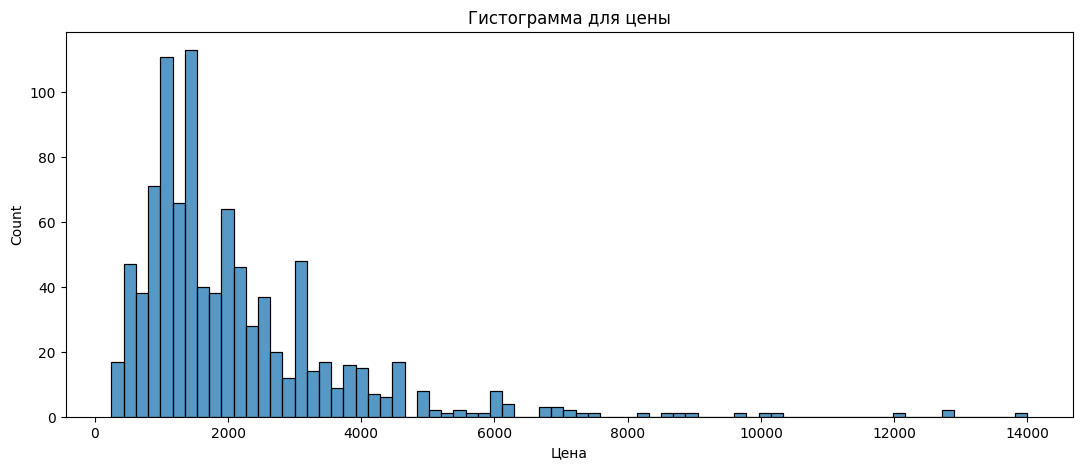

In [37]:
plt.figure(figsize=(13,5))
sns.histplot(x='Цена',data = df, bins=75)
plt.title('Гистограмма для цены')
plt.xlabel('Цена')

Text(0, 0.5, 'Цена')

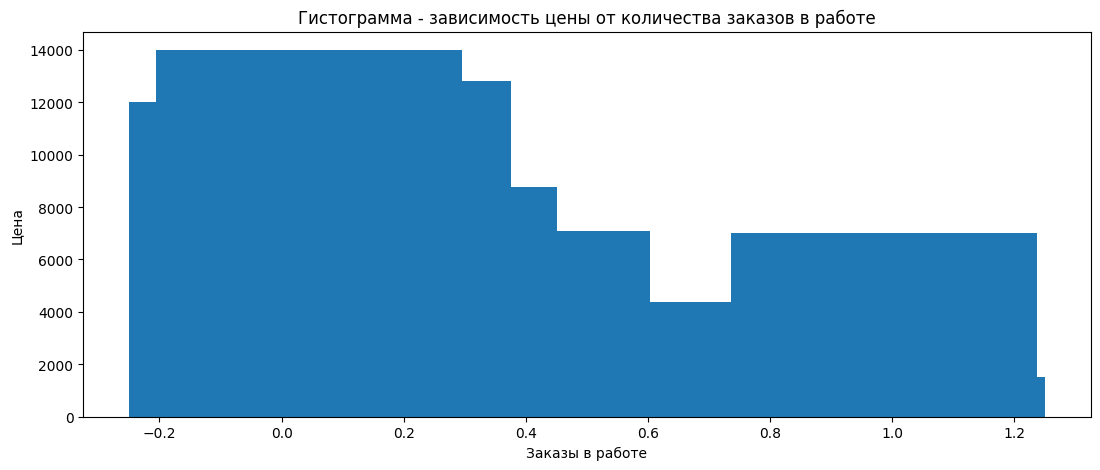

In [48]:
plt.figure(figsize=(13,5))
plt.bar(df['Заказы в работе'], df.Цена, width=0.5)
plt.title('Гистограмма - зависимость цены от количества заказов в работе')
plt.xlabel('Заказы в работе')
plt.ylabel('Цена')

Text(0, 0.5, 'Цена')

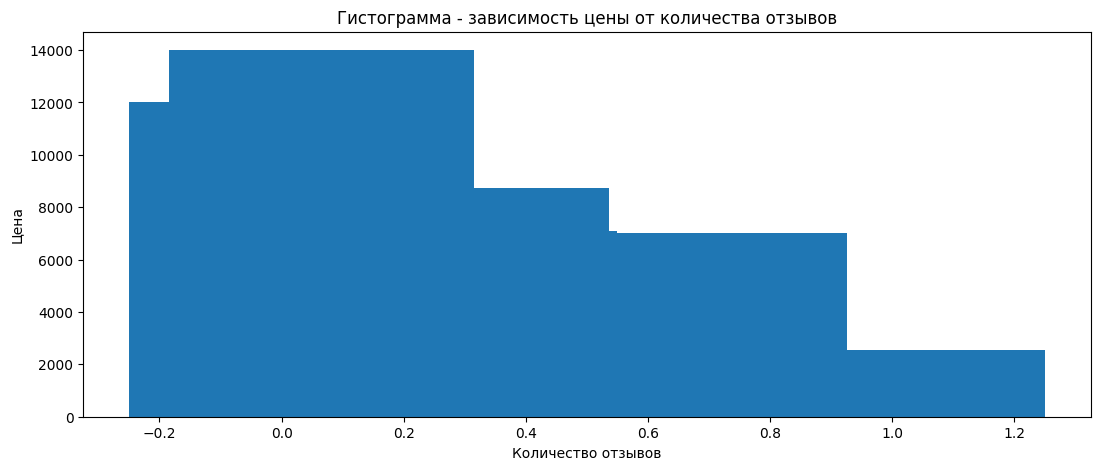

In [49]:
plt.figure(figsize=(13,5))
plt.bar(df['Количество отзывов'], df.Цена, width=0.5)
plt.title('Гистограмма - зависимость цены от количества отзывов')
plt.xlabel('Количество отзывов')
plt.ylabel('Цена')

Text(0.5, 1.0, 'Ящик с усами для цены в зависимости от топ-10 вузов')

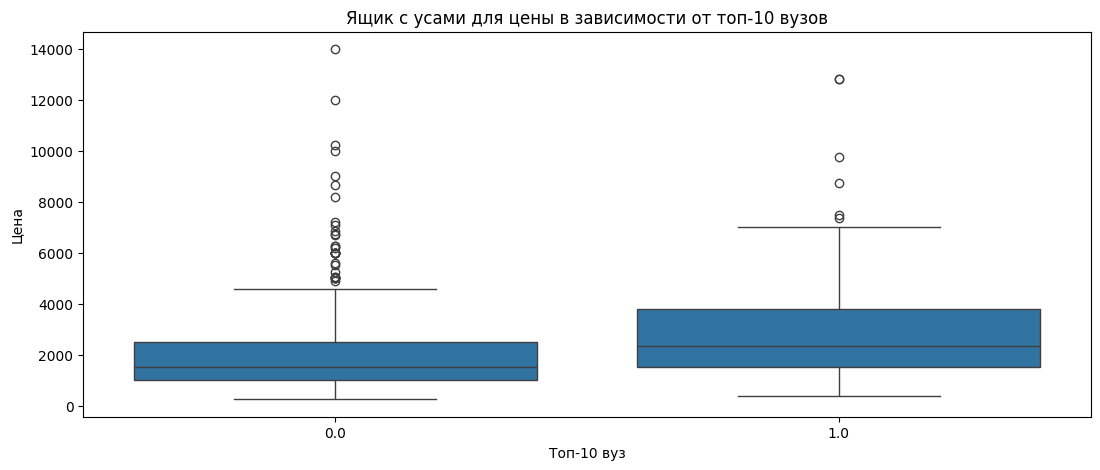

In [52]:
plt.figure(figsize=(13,5))
sns.boxplot(x='Топ-10 вуз',y='Цена',data = df)
plt.title('Ящик с усами для цены в зависимости от топ-10 вузов')


Если преподаватель закончил один из топ-10 вузов, то его цена будет в среднем выше, чем у преподавателя, такой вуз не оканчивавшего, как видно из графика

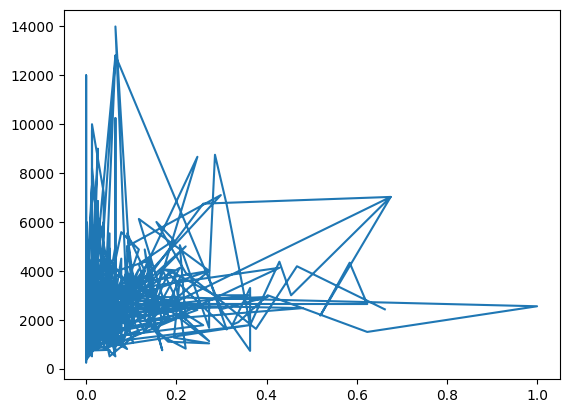

In [39]:
plt.plot(df['Количество отзывов'], df.Цена)

Отсюда следует, что линейный график не сильно информативен, мягко говоря!

<Axes: xlabel='Предмет', ylabel='Цена'>

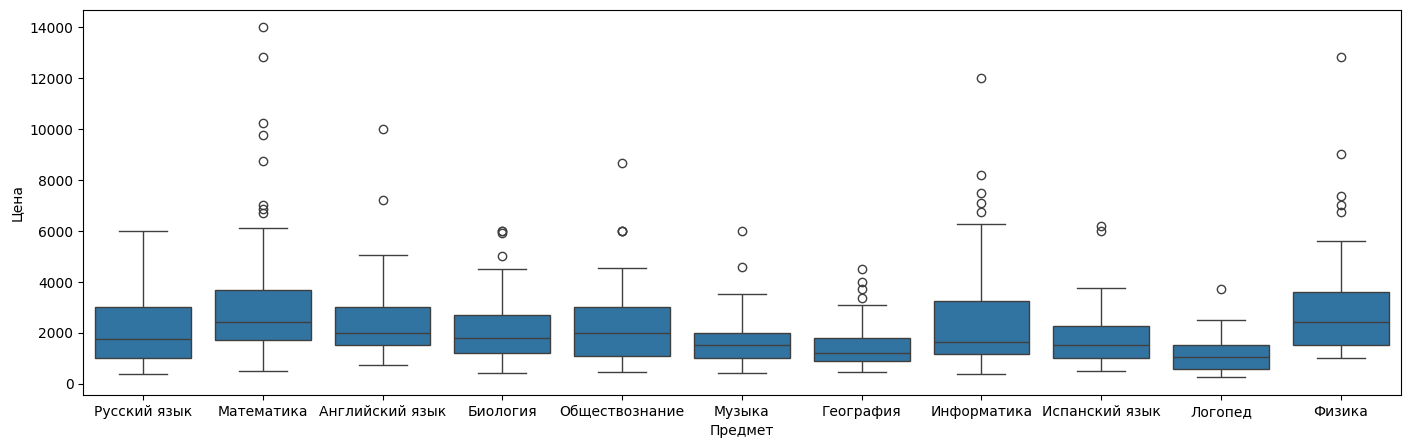

In [78]:
plt.figure(figsize=(17,5))
sns.boxplot(x='Предмет',y='Цена',data = df_raw)

Нет такого предмета, который можно было бы выделить относительно других, все +- в одном ценовом диапазоне

## Черновая функция get_tutor() и проч.

In [15]:
url = f'https://repetitor.ru/view/repetitor-po-matematike-tkachenko-olga-vladimirovna' ## https://repetitor.ru/view/repetitor-po-himii-cun-iosif-mendelevich-37447
response = requests.get(url)
tree = BeautifulSoup(response.content, 'html.parser')

In [16]:
#страница! препода
tutor_raw_inf = tree.body.find_all('div', {'class' : 'tutor__wrap'})[0]

In [17]:

#здесь я определяю стаж и статус
status_staj_raw = tutor_raw_inf.find('p', {'class' : "tutor-head__meta"}).text.strip().split('\n')
status = status_staj_raw[0].split(', ')[0]
staj = status_staj_raw[-1].split()[0]
status

'Частный преподаватель'

In [18]:
#определяю кол-во времени репета на сайте и кол-во заказов в работе
try:
  onsite_orders_raw = tutor_raw_inf.find('div', {'class' : "tutor-head__activity"}).text.strip().split('/')
  onsite = onsite_orders_raw[0].split()[-2:]
  if onsite[0] == 'Меньше':
    real_onsite = 0
  else:
    real_onsite = int(onsite[0])/12 if onsite[1] in ['месяца', 'месяцев'] else onsite[0]
except:
  real_onsite = None

try:
  orders = onsite_orders_raw[1].strip().split()[0]
except:
  orders = None

real_onsite, orders

('4', '78')

In [19]:
#здесь я определяю оценку
try:
  mark = tutor_raw_inf.find('div', {'class' : "tutor-head__rating-count"}).text.strip()
except:
  mark = None
mark

'4.96'

In [20]:
#здесь я определяю количество отзывов
try:
  number_of_review = tutor_raw_inf.find('div', {'class' : "tutor-head__rating"}).a.text.strip().split()[0]
except:
  number_of_review = None
number_of_review

'48'

In [21]:
#здесь я определяю формат занятий - дистанционно али очно
try:
  format_of_study = tutor_raw_inf.find('div', {'class' : "tutor-format__switches tabs__switches"}).button.text
except:
  format_of_study = None
format_of_study

'Дистанционно'

In [22]:
#здесь я нахожу среднюю цену, взвешенную по времени
prices_raw = tutor_raw_inf.find('div', {'class' : "tutor-format__prices"})
prices = prices_raw.find_all('td')[1::2]
price = 0
for price_elem in prices:
  price_currency, time_minute = str(price_elem).strip('</td>').split('/')
  price_without_currency = price_currency.split()[0]
  time_hour = int(time_minute.split()[0])/60
  price += float(price_without_currency) * time_hour
price /= len(prices)
price

2641.6666666666665

In [23]:
#определяю образование
try:
  tutor_education = tutor_raw_inf.find('table', {'class' : "tutor-education__table"}).span.text.strip()
  if 'С отличием' in tutor_education:
    flag = 1
    tutor_education = tutor_education[:tutor_education.rfind('С отличием')-2]
  elif 'с отличием' in tutor_education:
    flag = 1
    tutor_education = tutor_education[:tutor_education.rfind('с отличием')-2]
except:
  tutor_education = None
tutor_education

'СКФУ (Северо-Кавказский федеральный университет'

In [24]:
# определяю, подтверждена ли личность репетитора (True - подтверждена; False - нет)
tutor_person_confirmed_raw = tutor_raw_inf.find('div', {'class' : 'tutor-badge-blue'})
if type(tutor_person_confirmed_raw) == Tag:
  tutor_person_confirmed = True
else:
  tutor_person_confirmed = False

tutor_person_confirmed

True

In [25]:
df.isnull().sum()

Личность подтверждена                                 0
Стаж                                                  0
На сайте                                              0
Заказы в работе                                       0
Оценка                                                0
Количество отзывов                                    0
С отличием                                            0
Низкая оценка                                         0
Большой стаж                                          0
Языковой предмет                                      0
Топ-10 вуз                                            0
Топ-20 вуз                                            0
Предмет ЕГЭ                                           0
Гуманитарная наука                                    0
Естественная наука                                    0
Техническая наука                                     0
Статус_Аспирант или ординатор очной формы обучения    0
Статус_Преподаватель университета или колледжа  

In [26]:
df['Низкая оценка'] = (df['Оценка'].astype(float) < 4.5).astype(int)
df['Большой стаж'] = (df['Стаж'].astype(int) > 10).astype(int)
lang_lst = ['Русский язык', 'Английский язык', 'Испанский язык']
df['Языковой предмет'] = df['Предмет'].isin (lang_lst).astype(int)
top_ten = ['Национальный исследовательский Томский политехнический университет', 'МГУ им. М. В. Ломоносова', 'ФГАОУ ВО НИ ТПУ', 'ТПУ', 'Томский политехнический университет', 'Московский физико-технический институт (МФТИ)', 'Московский физико-технический институт (национальный исследовательский университет)', 'МФТИ (национальный исследовательский университет)', 'Национальный исследовательский университет "Московский физико-технический институт"', 'НИУ МФТИ', 'МФТИ', 'Московский физико-технический институт', 'Московский физико-технический институт (МФТИ)', 'Национальный исследовательский университет Московский физико-технический институт', 'НИУ Московский физико-технический институт', 'Московский Государственный Университет им. М.В.Ломоносова', 'МГУ им. М.В. Ломоносова', 'Московский государственный университет имени М.В. Ломоносова', 'МГУ', 'МГУ имени М.В.Ломоносова', 'МГУ имени М.В. Ломоносова', 'Московский Государственный Университет им. М.В. Ломоносова', 'Московский государственный университет имени М.В.Ломоносова', 'Санкт-Петербургский государственный университет', 'СПбГУ', 'Санкт-Петербургский университет', 'СПбУ', 'Национальный исследовательский ядерный университет «МИФИ»', 'НИЯУ МИФИ', 'МИФИ', 'Национальный исследовательский ядерный университет Московский инженерно-физический институт', 'НИЯУ Московский инженерно-физический институт', 'Московский инженерно-физический институт', 'Московский государственный технический университет имени Н.Э. Баумана', 'Московский государственный технический университет им. Н.Э. Баумана', 'Московский государственный технический университет имени Н.Э.Баумана', 'Московский государственный технический университет им. Н.Э.Баумана' , 'МГТУ им. Н.Э. Баумана', 'МГТУ им. Н.Э.Баумана', 'МГТУ имени Н.Э. Баумана', 'МГТУ имени Н.Э.Баумана', 'МГТУ', 'Национальный исследовательский университет "Высшая школа экономики"', 'НИУ ВШЭ', 'Высшая школа экономики', 'Национальный исследовательский университет ВШЭ', 'Национальный исследовательский университет «Высшая школа экономики» (НИУ ВШЭ)', 'НИУ Высшая школа экономики', 'ВШЭ', 'Московский Государственный Институт Международных Отношений', 'МГИМО', 'МГИМО МИД России', 'Московский государственный институт международных отношений МИД Российской Федерации', 'Московский государственный институт международных отношений МИД РФ', 'Московский государственный институт международных отношений МИД России', 'МГИМО МИД Российской Федерации', 'МГИМО МИД РФ', 'Санкт-Петербургский политехнический университет Петра Великого', 'ФГАОУ ВО СПбПУ', 'СПбПУ', 'ФГАОУ ВО «СПбПУ»', 'Политех', 'Санкт-Петербургский политехнический университет Петра Великого', 'Уральский федеральный университет имени первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н. Ельцина', 'Уральский федеральный университет имени первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет им. первого Президента России Б.Н.Ельцина', 'Уральский федеральный университет имени Б.Н. Ельцина', 'Уральский федеральный университет им. Б.Н.Ельцина', 'ФГАОУ ВО «УрФУ имени первого Президента России Б.Н. Ельцина»', 'Уральский федеральный университет', 'УрФУ', 'МФТИ, Московский Физико-Технический Институт (государственный исследовательский университет)', 'НИЯУ МИФИ', 'Ленинградский государственный университет (СПбГУ)', 'Национальный исследовательский университет «Высшая школа экономики»', 'УРФУ', 'Московский Государственный Университет имени М. В. Ломоносова', 'МГУ им. М.В. Ломоносова', 'МГУ им.М.В.Ломоносова', 'МГУ имени Ломоносова']
df['Топ-10 вуз'] = df['Образование'].isin (top_ten).astype(int)
top_twenty = ['Национальный исследовательский технологический университет "МИСИС"', 'Новосибирский национальный исследовательский государственный университет', 'НГУ', 'Новосибирский государственный университет', 'Финансовый университет при Правительстве РФ', 'Финансовый университет при Правительстве', 'Финансовый университет', 'Финансовый университет при Правительстве России', 'Финансовый университет при Правительстве Российской Федерации', 'Российская академия народного хозяйства и государственной службы при Президенте РФ', 'Российская академия народного хозяйства и государственной службы при Президенте', 'Российская академия народного хозяйства и государственной службы при Президенте России', 'Российская академия народного хозяйства и государственной службы при Президенте Российской Федерации', 'РАНХиГС', 'РАНХИГС', 'Санкт-Петербургский национальный исследовательский университет информационных технологий, механики и оптики', 'Национальный исследовательский университет ИТМО', 'НИУ ИТМО', 'НИУ информационных технологий, механики и оптики', 'Плехановский университет', 'Российский экономический университет имени Г.В. Плеханова', 'Российский экономический университет им. Г.В. Плеханова', 'Российский экономический университет имени Г.В.Плеханова', 'Российский экономический университет им. Г.В.Плеханова', 'РЭУ имени Г.В. Плеханова', 'РЭУ им. Г.В. Плеханова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет имени И.М. Сеченова', 'Первый Московский государственный медицинский университет имени И.М. Сеченова Минздрава РФ', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава России', 'Первый Московский государственный медицинский университет им. И.М. Сеченова', 'Первый Московский государственный медицинский университет им. И.М. Сеченова Минздрава РФ', 'Первый МГМУ им. И. М. Сеченова', 'Первый МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И.М. Сеченова Минздрава России', 'МГМУ им. И. М. Сеченова', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России (Сеченовский Университет)', 'ФГАОУ ВО Первый МГМУ им. И.М. Сеченова Минздрава России', 'Сеченовский Университет', 'Университет науки и технологий МИСИС', 'Университет науки и технологий «МИСиС»', 'Национальный исследовательский технологический университет «МИСиС»', 'МИСиС', 'МИСИС', 'НИТУ МИСиС', 'НИТУ «МИСиС»', 'Национальный исследовательский Томский государственный университет', 'ТГУ', 'Томский государственный университет', 'НИ ТГУ', 'Российский университет дружбы народов', 'Российский университет дружбы народов (РУДН)', 'Российский университет дружбы народов имени Патриса Лумумбы', 'Российский университет дружбы народов им. Патриса Лумумбы', 'РУДН', 'Казанский (Приволжский) федеральный университет', 'ФФГАОУВО КФУ', 'ФФГАОУВО "КФУ"', 'КФУ', 'Казанский федеральный университет', 'Приволжский федеральный университет', 'Казанский университет']
df['Топ-20 вуз'] = df['Образование'].isin (top_twenty).astype(int)
rse_lst = ['Русский язык', 'Математика', 'Английский язык','Биология', 'Обществознание', 'География', 'Информатика', 'Физика', 'Химия', 'Испанский язык']
df['Предмет ЕГЭ'] = df['Предмет'].isin (rse_lst).astype(int)
gumant = ['Русский язык', 'Английский язык', 'Обществознание', 'Испанский язык']
estestv = ['Биология', 'Физика', 'Химия', 'География']
tehnich = ['Математика', 'Информатика', 'Экономика']

df['Гуманитарная наука'] = df['Предмет'].isin (gumant).astype(int)
df['Естественная наука'] = df['Предмет'].isin (estestv).astype(int)
df['Техническая наука'] = df['Предмет'].isin (tehnich).astype(int)
df

KeyError: 'Предмет'

In [ ]:
df['Топ-20 вуз'].sum()

In [ ]:
df['Топ-10 вуз'].sum()

In [ ]:
df['Низкая оценка'].sum()